In [1]:
import torch
from torch.nn import NLLLoss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn

%matplotlib inline
import pylab as pl
from IPython import display
import time

from helpful_files.networks import Network
from helpful_files.training import *

In [2]:
# Set Important Values

# General settings
datapath = '/data/dww78/mini_inat_shrunk/'                     # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
savepath = 'L2-Norm-proto-Train-100.pth'            # Where should your trained model(s) be saved, and under what name?
gpu = 0                             # What gpu do you wish to train on?
workers = 1                         # Number of cpu worker processes to use for data loading
epoch = 10                          # Number of passes over the dataset before the learning rate is cut
ncuts = 5                           # Number of times to cut the learning rate before training completes
verbosity = 50                      # How many batches in between status updates 
ensemble = 4                        # How many models to train in parallel
torch.cuda.set_device(gpu)
cudnn.benchmark = True

# Batch construction
way = 20                            # Number of classes per batch during training
trainshot = 5                       # Number of images per class used to form prototypes
testshot = 15                       # Number of images per class used to make predictions

# Model construction
folding = True                      # Use batch folding?
covariance_pooling = False           # Use covariance pooling?
localizing = False                   # Use localization?
fewshot_local = False                # If you are using localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 64                  # Number of channels at every layer of the network

# Data loading
augmentation_flipping = True        # Horizontal flip data augmentation
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)

In [3]:
# Load Training Data

d_boxes = torch.load(datapath + 'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

if folding:
    # Batch folding has no reference/query distinction
    shots = [trainshot+testshot]
else:
    # Standard setup
    shots = [trainshot, testshot]
if localizing and fewshot_local and not folding:
    # Unfolded prototype localizers need another set of reference images to inform foreground/background predictions
    shots = [trainshot, trainshot, testshot-trainshot]
    
train_dataset = datasets.ImageFolder(
    datapath+'train', 
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way, shots),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')

Data loaded!


In [4]:
# Make Models
    
models = [Network(network_width, folding, covariance_pooling, 
                  localizing, fewshot_local, shots).cuda() 
          for i in range(ensemble)]
optimizer = [optim.Adam(m.parameters(), lr=.001) for m in models]
scheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in optimizer]
criterion = NLLLoss().cuda()

nweights = sum([i.numel() for i in list(models[0].parameters())])
print(nweights,"parameters in each neural net.")
print('Ready to go!')

113088 parameters in each neural net.
Ready to go!


In [5]:
#                                             TRAINING

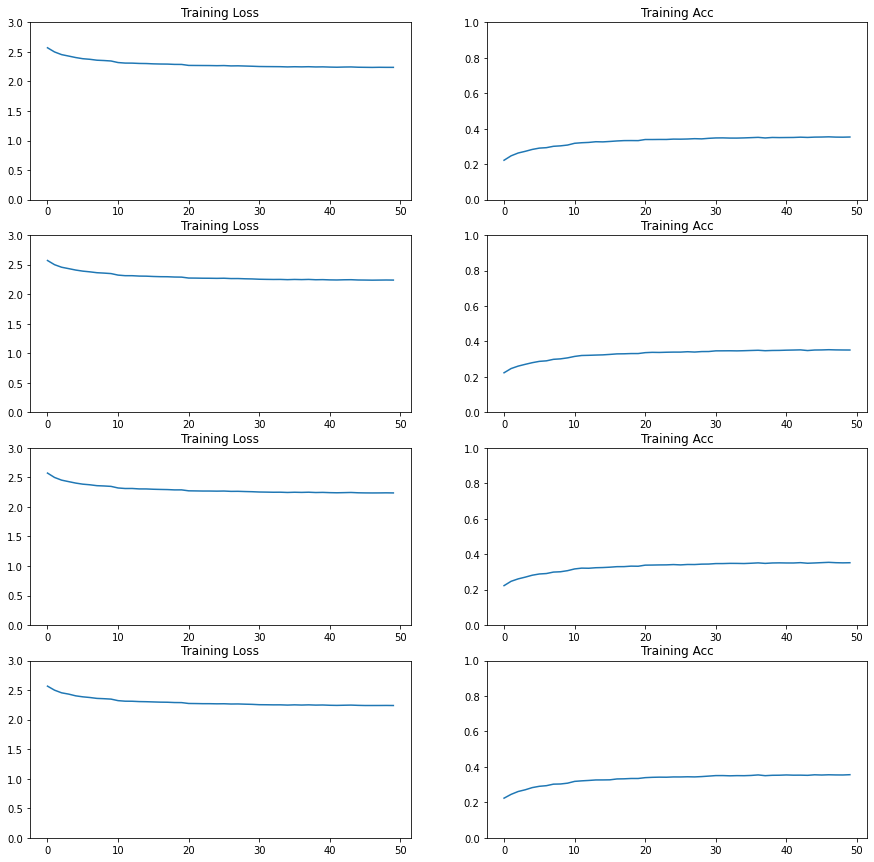

Training loss is: [2.2390812005207037, 2.2388681935150405, 2.2366950967509274, 2.238933375939695]
Training accuracy is: [0.353423566878981, 0.35177813163481947, 0.35177282377919317, 0.3559819532908705]

Approximately 0.10 hours to completion

Training complete: 4.91 hours total


In [6]:
# Do the Thing!

start = time.time()
trainlosses, acctracker = [[] for _ in range(ensemble)],[[] for _ in range(ensemble)]
epochs = ncuts*epoch
for e in range(epochs):
    
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in scheduler]
    
    # Train for one epoch
    trainloss, acc = train(train_loader, models, optimizer, criterion, way, shots, verbosity)
    
    # Update the graphics, report
    display.clear_output(wait=True)
    for j in range(ensemble):
        trainlosses[j].append(trainloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(ensemble):
        pl.subplot(ensemble,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.ylim((0,3))
        pl.title("Training Loss")
        pl.subplot(ensemble,2,2*i+2)
        pl.plot(acctracker[i])
        pl.ylim((0,1))
        pl.title("Training Acc")
    pl.show()
    print("Training loss is: "+str(trainloss)+
            "\nTraining accuracy is: "+str(acc)+"\n")
    print("Approximately %.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
    
print("Training complete: %.2f hours total" % ((time.time()-start)/3600)) 

In [7]:
# Save the model

torch.save([m.encode.cpu().state_dict() for m in models], savepath)

# If using parametric localization, save the extra parameters
if localizing and not fewshot_local:
    torch.save([m.postprocess.centroids.cpu() for m in models], 
               savepath[:savepath.rfind('.')]+'_localizers'+savepath[savepath.rfind('.'):])
print("Models saved!")

Models saved!


In [ ]:
# Shut down the notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>